### Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
# from absl import flags
import tensorflow as tf
import tensorflow_privacy
from keras.models import Model
import matplotlib.pyplot as plt
from skimage.feature import hog
from PIL import Image, ImageOps
import tensorflow_addons as tfa
from keras.layers.convolutional import Conv2D
from tensorflow.keras.datasets import cifar10
from tensorflow_addons.layers import GroupNormalization
from keras.layers import Input, Dense, Flatten, Dropout, Add, LayerNormalization
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
tf.compat.v1.disable_v2_behavior()
tf.get_logger().setLevel('ERROR')
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


### Load Dataset

In [2]:
def hog_transform(train):
    train_hog = []
    for sample in train:
        img = Image.fromarray(np.uint8(sample)).convert('RGB')
        img = ImageOps.grayscale(img)
        hog_features = hog(img, orientations = 9, pixels_per_cell = (2, 2), 
                           cells_per_block = (1, 1), block_norm = 'L2', visualize = False)
        train_hog.append(hog_features)
    train_hog = np.array(train_hog)
    return train_hog

In [3]:
# Loading cifar10 image dataset
data_train, data_test = cifar10.load_data()
x_train, y_train = data_train
x_test, y_test = data_test

# Hog transformations of images
x_train_hog = hog_transform(x_train)
x_test_hog = hog_transform(x_test)

# Normalizing pixel values of images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flattening images in dataset
y_train = y_train.flatten().reshape(y_train.shape[0], 1)
y_test = y_test.flatten().reshape(y_test.shape[0], 1)

# One hot encoding of labels/target column
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print("training:", x_train.shape, y_train.shape)
print("testing:", x_test.shape, y_test.shape)
print("--------------------------------")
print("hog training:", x_train_hog.shape, y_train.shape)
print("hog testing:", x_test_hog.shape, y_test.shape)

### Model: HOG + ANN

In [27]:
### Hyper-parameters

# epochs = 130
# batch_size = 500
# l2_norm_clip = 1
# noise_multiplier = 1.3
# num_microbatches = 100
# learning_rate = 0.15
# delta = 1e-5

epochs = 100
batch_size = 2000
l2_norm_clip = 1.2
noise_multiplier = 2.06
num_microbatches = 100
learning_rate = 0.085
delta = 1e-5

### HOG training
x_train = x_train_hog
x_test = x_test_hog

if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')
    
# Compute RDP
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
rdp = compute_rdp(q = batch_size / 50000,
                  noise_multiplier = noise_multiplier,
                  steps = epochs * 50000 // batch_size,
                  orders = orders)
# Calculate epsilon
epsilon = get_privacy_spent(orders, rdp, target_delta = delta)[0]
epsilon

4.998994314017812

In [6]:
## Extra Testing
epochs = 10 
batch_size = 250 
l2_norm_clip = 1 
noise_multiplier = 1.25 
num_microbatches = batch_size
learning_rate = 0.25   
delta = 1e-5

if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')
    
# Compute RDP
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
rdp = compute_rdp(q = batch_size / 50000,
                  noise_multiplier = noise_multiplier,
                  steps = epochs * 50000 // batch_size,
                  orders = orders)
# Calculate epsilon
epsilon = get_privacy_spent(orders, rdp, target_delta = delta)[0]
epsilon

0.9262950367654832

In [28]:
### CNN network
# model_input = Input(shape = (32, 32, 3))
model_input = Input(shape = (2304))
# x1 = Conv2D(16, (8, 8), activation = 'tanh', strides = 2)(model_input)
# x1 = LayerNormalization()(x1)
# x1 = Dropout(0.4)(x1)
# x2 = MaxPooling2D(pool_size = (2,1))(x1)
# x3 = Conv2D(32, (4, 4), activation = 'tanh', strides = 2)(x2)
# x4 = MaxPooling2D(pool_size = (2,1))(x3)
# x4 = LayerNormalization()(x4)
# ftn = Flatten()(x4)
### Feed-forward network
d1 = Dense(8, activation = 'tanh')(model_input)
d1 = Dropout(0.1)(d1)
d2 = Dense(16, activation = 'tanh')(d1)
d2 = LayerNormalization()(d2)
# sk1 = Add()([d1, d3])
d4 = Dense(16, activation = 'tanh')(d2)
d4 = Dropout(0.1)(d4)
d5 = Dense(8, activation = 'tanh')(d4)
d5 = LayerNormalization()(d5)
d6 = Dense(8, activation = 'tanh')(d5)
model_output = Dense(10, activation = 'softmax')(d6)
model = Model(inputs = model_input, outputs = model_output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2304)]            0         
                                                                 
 dense_16 (Dense)            (None, 8)                 18440     
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 16)                144       
                                                                 
 layer_normalization_4 (Laye  (None, 16)               32        
 rNormalization)                                                 
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                           

In [29]:
# define optimizer (dp-sgd) 
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# # define optimizer (dp-adam)
# optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate,
#     gradient_accumulation_steps=5)

# define loss function
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [30]:
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# Train model
model.fit(x_train, y_train,
          epochs=epochs,
          validation_data=(x_test, y_test),
          batch_size=batch_size)

Train on 50000 samples, validate on 10000 samples


2022-03-26 18:29:37.576351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-26 18:29:38.218767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-03-26 18:29:38.449792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-26 18:29:38.571973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - ETA: 0s - loss: 2.3785 - acc: 0.1069

2022-03-26 18:33:08.418673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - 210s 4ms/sample - loss: 2.3785 - acc: 0.1069 - val_loss: 2.3322 - val_acc: 0.1247
Epoch 2/100
50000/50000 [==============================] - 168s 3ms/sample - loss: 2.3288 - acc: 0.1231 - val_loss: 2.2945 - val_acc: 0.1432
Epoch 3/100
50000/50000 [==============================] - 166s 3ms/sample - loss: 2.2918 - acc: 0.1381 - val_loss: 2.2607 - val_acc: 0.1585
Epoch 4/100
50000/50000 [==============================] - 166s 3ms/sample - loss: 2.2596 - acc: 0.1586 - val_loss: 2.2258 - val_acc: 0.1744
Epoch 5/100
50000/50000 [==============================] - 169s 3ms/sample - loss: 2.2271 - acc: 0.1701 - val_loss: 2.1870 - val_acc: 0.1862
Epoch 6/100
50000/50000 [==============================] - 168s 3ms/sample - loss: 2.1883 - acc: 0.1794 - val_loss: 2.1587 - val_acc: 0.1885
Epoch 7/100
50000/50000 [==============================] - 167s 3ms/sample - loss: 2.1637 - acc: 0.1899 - val_loss: 2.1320 - val_acc: 0.1969
Epoch 8/100
50000/50000 [

Epoch 59/100
50000/50000 [==============================] - 133s 3ms/sample - loss: 1.8860 - acc: 0.3059 - val_loss: 1.8770 - val_acc: 0.3089
Epoch 60/100
50000/50000 [==============================] - 132s 3ms/sample - loss: 1.8823 - acc: 0.3058 - val_loss: 1.8739 - val_acc: 0.3067
Epoch 61/100
50000/50000 [==============================] - 133s 3ms/sample - loss: 1.8772 - acc: 0.3093 - val_loss: 1.8727 - val_acc: 0.3111
Epoch 62/100
50000/50000 [==============================] - 133s 3ms/sample - loss: 1.8770 - acc: 0.3102 - val_loss: 1.8711 - val_acc: 0.3159
Epoch 63/100
50000/50000 [==============================] - 133s 3ms/sample - loss: 1.8771 - acc: 0.3112 - val_loss: 1.8697 - val_acc: 0.3146
Epoch 64/100
50000/50000 [==============================] - 133s 3ms/sample - loss: 1.8743 - acc: 0.3126 - val_loss: 1.8670 - val_acc: 0.3128
Epoch 65/100
50000/50000 [==============================] - 133s 3ms/sample - loss: 1.8709 - acc: 0.3146 - val_loss: 1.8637 - val_acc: 0.3180
Epoch 

KeyboardInterrupt: 

### HOG testing

In [320]:
# x_train_hog = []
# for sample in x_train:
#     hog_features = extract_hog(sample)
#     x_train_hog.append(hog_features)
# x_train_hog = np.array(x_train_hog)

In [307]:
# Image.fromarray(np.uint8(hog_image)) #.resize((300, 300)) #.convert('RGB') 

features: 80


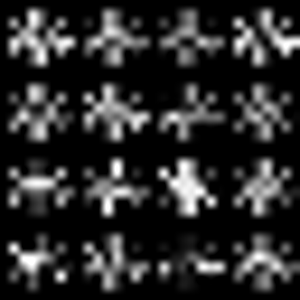

In [7]:
def extract_hog(sample):
    img = Image.fromarray(np.uint8(sample)).convert('RGB')
    img = ImageOps.grayscale(img)
    hog_features, hog_image = hog(img, orientations = 5, pixels_per_cell = (8, 8),
                                 cells_per_block = (4, 4), block_norm = 'L2', visualize = True)
    return hog_features, hog_image
    
hog_features, hog_image = extract_hog(x_train[5])
print('features:',len(hog_features))
# hog_image.reshape(-1)
thresholded_img = np.array([0 if p == 0 else p*29 for p in hog_image.reshape(-1)]).reshape((32, 32))
Image.fromarray(np.uint8(thresholded_img)).resize((300, 300))